In [ ]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# train/test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# LR
from sklearn.linear_model import LinearRegression

# SVR
from sklearn.svm import SVR

# Others
from scipy.spatial.distance import cdist
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
# Path to the CSV file (adjust if the file is elsewhere)
file_path = '../Data/Base Columbus.csv'

# Read the CSV file
df = pd.read_csv(file_path, index_col=0)

# Quick check
print("Shape of the DataFrame:", df.shape)
display(df.head())

# Explicit conversion to float for safety
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')

# Create geometry from X (lon), Y (lat) columns
geometry = [Point(xy) for xy in zip(df["X"], df["Y"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  # WGS84 (lat/lon)

# Convert to projected coordinates (UTM zone appropriate for df, Ohio ≈ EPSG:26917)
gdf_proj = gdf.to_crs(epsg=26917)

# Add new columns with coordinates in meters
gdf_proj["X_m"] = gdf_proj.geometry.x
gdf_proj["Y_m"] = gdf_proj.geometry.y

# Extract projected coordinates as array for spatial analysis
coords_df = gdf_proj[['X_m', 'Y_m']].values

# Verify
print("\nConverted coordinates (in meters):")
display(gdf_proj[['X_m', 'Y_m']].head())

df['X'] = pd.to_numeric(gdf_proj['X_m'], errors='coerce')
df['Y'] = pd.to_numeric(gdf_proj['Y_m'], errors='coerce')

Shape del DataFrame: (49, 22)


,AREA,PERIMETER,COLUMBUS.,COLUMBUS.I,POLYID,NEIG,HOVAL,INC,CRIME,OPEN,...,X,Y,AREA.1,NSA,NSB,EW,CP,THOUS,NEIGNO,PERIM
1005,0.309441,2.440629,2,5,1,5,80.467003,19.531,15.725980,2.850747,...,38.799999,44.070000,10.391,1,1,1,0,1000,1005,2.440629
1001,0.259329,2.236939,3,1,2,1,44.567001,21.232,18.801754,5.296720,...,35.619999,42.380001,8.621,1,1,0,0,1000,1001,2.236939
1006,0.192468,2.187547,4,6,3,6,26.350000,15.956,30.626781,4.534649,...,39.820000,41.180000,6.981,1,1,1,0,1000,1006,2.187547
1002,0.083841,1.427635,5,2,4,2,33.200001,4.477,32.387760,0.394427,...,36.500000,40.520000,2.908,1,1,0,0,1000,1002,1.427635
1007,0.488888,2.997133,6,7,5,7,23.225000,11.252,50.731510,0.405664,...,40.009998,38.000000,16.827,1,1,1,0,1000,1007,2.997133



Coordenadas convertidas (en metros):


,X_m,Y_m
1005,5.165444e+06,1.302427e+07
1001,5.565641e+06,1.290941e+07
1006,5.409475e+06,1.337741e+07
1002,5.725132e+06,1.315665e+07
1007,5.737799e+06,1.371494e+07


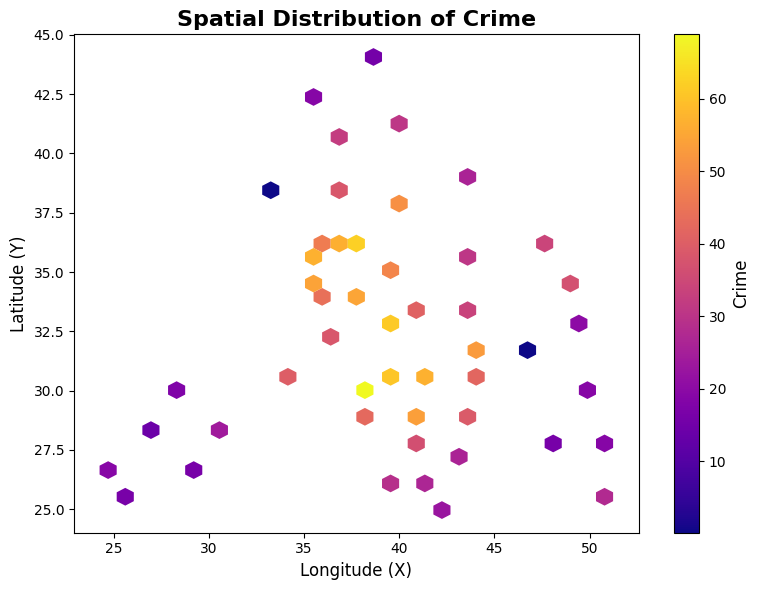

In [ ]:
# Spatial Plot of Columbus
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
ax.set_facecolor('white')  # Clean, high-contrast background for publication-quality plots

hb = ax.hexbin(
    df['X'], df['Y'], C=df['CRIME'],
    gridsize=30,
    cmap='plasma',  # Alternative: 'viridis' or 'magma'
    edgecolors='none'
)

cb = fig.colorbar(hb, ax=ax)
cb.set_label("Crime", fontsize=12)

ax.set_xlabel("Longitude (X)", fontsize=12)
ax.set_ylabel("Latitude (Y)", fontsize=12)
ax.set_title("Spatial Distribution of Crime", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Define Features and Target
predictor_cols = ['INC', 'HOVAL', 'PLUMB', 'DISCBD']
target_col = 'CRIME'
coords_cols = ['X', 'Y']

In [ ]:
# Split Data into Training and Testing Sets
train_data, test_data = train_test_split(df, test_size=0.15, random_state=118)

# Extract Values
X_train = train_data[predictor_cols].values
y_train = train_data[target_col].values.reshape(-1, 1)
coords_train = train_data[coords_cols].values

X_test = test_data[predictor_cols].values
y_test = test_data[target_col].values.reshape(-1, 1)
coords_test = test_data[coords_cols].values

# Standardize predictors for LR and SVR 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Define Kernel Functions
def gaussian_paper_kernel(distances, bandwidth):
    return np.exp(- (distances / bandwidth) ** 2)

kernel_functions = {
    'paper_gaussian': gaussian_paper_kernel
}

In [ ]:
# Initialize variables
intercept = True
kernel_name = 'paper_gaussian'
metric = 'euclidean'
n_max = 10  # Maximum number of neighbors to consider

kernel_func = kernel_functions[kernel_name]

time_start = time.time()

# Compute distance matrix between test and train coordinates
distances_matrix = cdist(coords_test, coords_train, metric=metric)
medians = np.median(distances_matrix, axis=1)

# Store results
CV = {}  # Stores Cross-validation errors
B = {}   # Stores bandwidths
predictions_dict = {}  # Stores predictions

# Loop through each test point
for i in range(len(coords_test)):
    best_cv_i = float('inf')
    best_prediction_i = None
    best_bw_i = None

    for n in range(1, n_max + 1):
        bw_manual = max(0.1 * (n+1) * np.median(distances_matrix[i]), 1e-6)

        n_samples = len(y_train)
        errors = []

        for j in range(n_samples):
            # Exclude the i-th observation to create training data
            X_train_e = np.delete(X_train_scaled, j, axis=0)
            y_train_e = np.delete(y_train, j, axis=0)
            coords_train_e = np.delete(coords_train, j, axis=0)

            # Calculate distances from the i-th observation to all training points
            distances = cdist([coords_train[j]], coords_train_e, metric='euclidean').flatten()
            # Compute weights using the kernel function
            weights_e = kernel_func(distances, bw_manual)
            weights_e /= np.sum(weights_e) if np.sum(weights_e) != 0 else 1  # Normalize weights

            # Fit weighted linear regression model
            model = LinearRegression()
            model.fit(X_train_e, y_train_e, sample_weight=weights_e)
            # Predict the left-out observation
            y_pred = model.predict([X_train_scaled[j]])

            # Calculate squared error
            errors.append((y_train[j] - y_pred) ** 2)

        # Compute mean CV error
        cv = np.mean(errors)
        CV[(i, n)] = cv

        # Update the best bandwidth if the current CV error is lower
        if cv < best_cv_i:
            best_cv_i = cv
            best_bw_i = bw_manual
            # Compute weights for the current bandwidth
            weights_vector = kernel_func(distances_matrix[i], best_bw_i)
            weights_vector /= np.sum(weights_vector) if np.sum(weights_vector) != 0 else 1  # Normalize weights

            # Fit the model with the best bandwidth
            model = LinearRegression()
            model.fit(X_train_scaled, y_train, sample_weight=weights_vector)
            # Predict the left-out observation
            best_prediction_i = model.predict(X_test_scaled[i].reshape(1, -1))[0][0]

    # Store the best bandwidth and prediction for the current test point
    B[i] = best_bw_i
    predictions_dict[i] = best_prediction_i

time_end = time.time()

gwr_time_locv = time_end - time_start

# Select the best configuration per test point
best_configs = {}
for i in range(len(coords_test)):
    filtered_cv = {k: v for k, v in CV.items() if k[0] == i}
    if filtered_cv:  # Ensure non-empty selection
        best_configs[i] = min(filtered_cv, key=filtered_cv.get)

print("\nBest configurations obtained for each test point:")
for i, best_config in best_configs.items():
    print(f"Test Point {i}: n={best_config[1]}, bandwidth={B[best_config[0]]:.2f}, CV Error={CV[best_config]:.2f}")

# Final Predictions using Best Configuration
predictions = []
for i in range(len(coords_test)):
    best_config = best_configs[i]
    key_without_n = (best_config[0])  
    predictions.append(predictions_dict[key_without_n])  

y_pred_gwr_paper_locv = np.array(predictions)



Best configurations obtained for each test point:
Test Point 0: n=7, bandwidth=966207.35, CV Error=122.19
Test Point 1: n=6, bandwidth=873369.72, CV Error=122.18
Test Point 2: n=6, bandwidth=955511.47, CV Error=122.07
Test Point 3: n=6, bandwidth=903700.66, CV Error=121.87
Test Point 4: n=7, bandwidth=888496.11, CV Error=121.98
Test Point 5: n=5, bandwidth=884528.38, CV Error=122.02
Test Point 6: n=7, bandwidth=908698.55, CV Error=121.85
Test Point 7: n=6, bandwidth=863088.90, CV Error=122.38


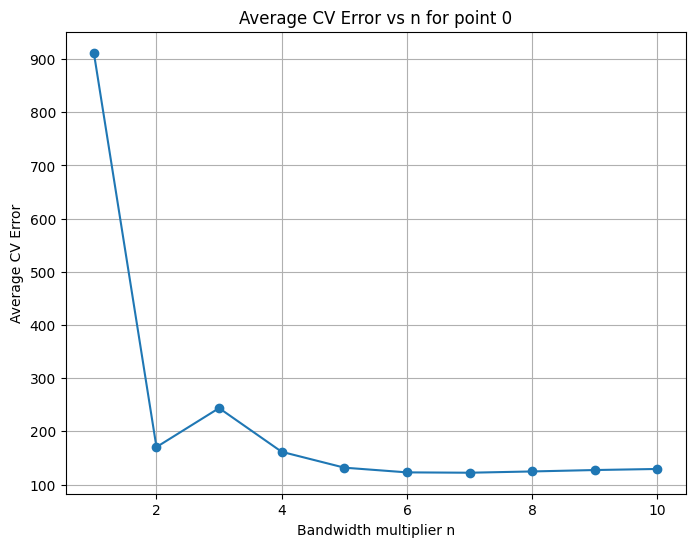

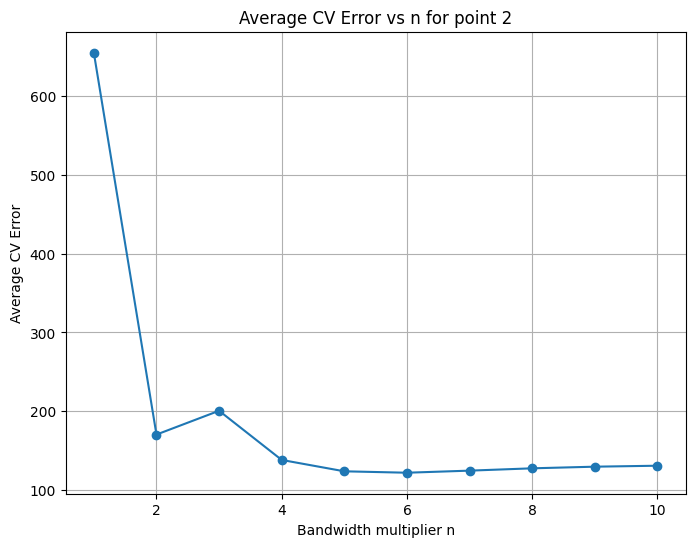

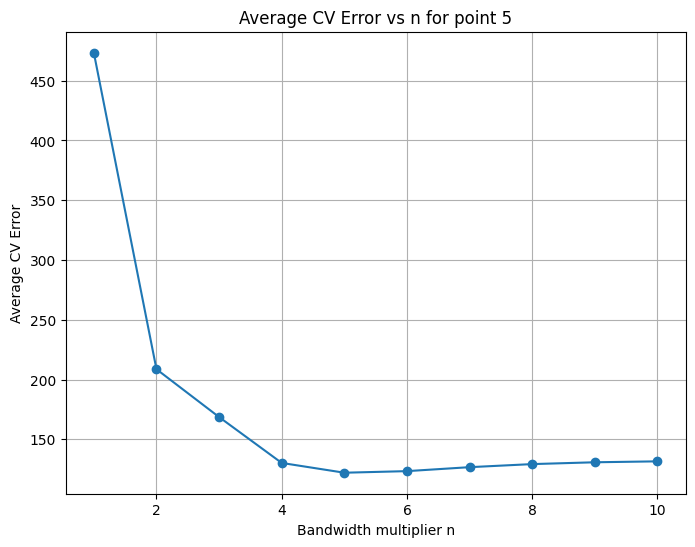

In [ ]:
for i in [0,2,5]:

    cv_errors_by_n = []

    for n in range(1, n_max + 1):
        key = (i, n)
        if key in CV:
            cv_errors_by_n.append(CV[key])

    # Produce the plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1,n_max+1), cv_errors_by_n, marker='o')
    plt.xlabel('Bandwidth multiplier n')
    plt.ylabel('Average CV Error')
    plt.title(f'Average CV Error vs n for point {i}')
    plt.grid(True)
    plt.show()

In [81]:
# Linear Regression
def linear_regression_state(X_train_scaled, y_train, X_test_scaled):
    lr_model = LinearRegression(fit_intercept=True)
    lr_model.fit(X_train_scaled, y_train)
    y_pred_lr = lr_model.predict(X_test_scaled)
    return y_pred_lr

In [ ]:
# Support Vector Regression
def svr_state(X_train_scaled, y_train, X_test_scaled, param_grids):
    grid_search = GridSearchCV(
        SVR(),
        param_grid=param_grids,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-2
    )
    grid_search.fit(X_train_scaled, y_train.ravel())
    best_svr = grid_search.best_estimator_
    y_pred_svr = best_svr.predict(X_test_scaled)
    return y_pred_svr

In [83]:
# Create a list of parameter grids for different kernels.
param_grids = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.01, 0.1, 0.5]
    },
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5]
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10, 100],
        'degree': [2, 3, 4],
        'epsilon': [0.01, 0.1, 0.5],
        'gamma': ['scale', 'auto'],
        'coef0': [0, 1]
    },
    {
        'kernel': ['sigmoid'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5],
        'gamma': ['scale', 'auto'],
        'coef0': [0, 1]
    }
]

In [ ]:
# GWR
def gwr_state(X_train, y_train, X_test, coords_train, coords_test, kernel_func, n_max=10, intercept=True, metric='euclidean'):

    # Store results properly
    predictions_dict = {}  # Stores predictions

    distances_matrix = cdist(coords_test, coords_train, metric=metric)

    # Loop through each test point
    for i in range(len(coords_test)):
        best_cv_i = float('inf')
        best_prediction_i = None
        best_bw_i = None

        for n in range(1, n_max + 1):
            bw_manual = max(0.1 * (n+1) * np.median(distances_matrix[i]), 1e-6)

            n_samples = len(y_train)
            errors = []

            for j in range(n_samples):
                # Exclude the i-th observation to create training data
                X_train_e = np.delete(X_train, j, axis=0)
                y_train_e = np.delete(y_train, j, axis=0)
                coords_train_e = np.delete(coords_train, j, axis=0)

                # Calculate distances from the i-th observation to all training points
                distances = cdist([coords_train[j]], coords_train_e, metric='euclidean').flatten()
                # Compute weights using the kernel function
                weights_e = kernel_func(distances, bw_manual)
                weights_e /= np.sum(weights_e) if np.sum(weights_e) != 0 else 1  # Normalize weights

                # Fit weighted linear regression model
                model = LinearRegression()
                model.fit(X_train_e, y_train_e, sample_weight=weights_e)
                # Predict the left-out observation
                y_pred = model.predict([X_train[j]])

                # Calculate squared error
                errors.append((y_train[j] - y_pred) ** 2)

            # Compute mean CV error
            cv = np.mean(errors)

            # Update the best bandwidth if the current CV error is lower
            if cv < best_cv_i:
                best_cv_i = cv
                best_bw_i = bw_manual
                # Compute weights for the current bandwidth
                weights_vector = kernel_func(distances_matrix[i], best_bw_i)
                weights_vector /= np.sum(weights_vector) if np.sum(weights_vector) != 0 else 1  # Normalize weights

                # Fit the model with the best bandwidth
                model = LinearRegression()
                model.fit(X_train, y_train, sample_weight=weights_vector)
                # Predict the left-out observation
                best_prediction_i = model.predict(X_test[i].reshape(1, -1))[0]

        # Store the best bandwidth and prediction for the current test point
        predictions_dict[i] = best_prediction_i

    # Final Predictions using Best Configuration
    y_pred_gwr_paper = np.array([predictions_dict[i] for i in range(len(coords_test))])


    return y_pred_gwr_paper


In [ ]:
# GW-SVR
def gwsvr_state(X_train, y_train, X_test, coords_train, coords_test, kernel_func = gaussian_paper_kernel, n_max = 10):

    X_train_manual = X_train #np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_test_manual  = X_test #np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Ensure targets are 1-dimensional
    y_train = y_train.ravel()

    # Store results
    predictions_dict = {}  # Stores best predictions

    # Compute distance matrix
    distances_matrix = cdist(coords_test, coords_train, metric='euclidean')


    # Define grid for hyperparameter tuning
    C_values = [240,250,255,256,260,270]
    epsilon_values = [0.1,0.01,1]
    gamma_values = [0.002,0.003,0.004,0.005,'auto']

    param_grid = {'C': C_values, 'gamma': gamma_values,'epsilon': epsilon_values}


    for i in range(len(coords_test)):
        best_cv_i = float('inf')
        best_prediction_i = None

        for n in range(1, n_max + 1):
            bw_manual = max(0.1 * (n+1) * np.median(distances_matrix[i]), 1e-6)

            # Compute weights using the chosen kernel function
            W = kernel_func(distances_matrix[i], bw_manual)
            W = W / np.sum(W)  # Normalize weights

            # Train SVR with GridSearchCV for hyperparameter tuning on the weighted training data.
            svr = SVR(kernel='rbf')
            grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error',n_jobs=-2)
            grid_search.fit(X_train_manual, y_train, sample_weight=W)

            # Get the cross-validation error (note: best_score_ is negative, so we take its negative)
            cv_candidate = -grid_search.best_score_

            # Get best hyperparameters for this candidate
            best_C = grid_search.best_params_['C']
            best_gamma = grid_search.best_params_['gamma']
            best_epsilon = grid_search.best_params_['epsilon']


            # If this candidate yields lower CV error, update the best configuration
            if cv_candidate < best_cv_i:
                best_cv_i = cv_candidate

                # Train the final model on the weighted training set using these best parameters
                svr_final = SVR(kernel='rbf', C=best_C, gamma=best_gamma, epsilon=best_epsilon)
                svr_final.fit(X_train_manual, y_train, sample_weight=W)
                y_pred = svr_final.predict(X_test_manual[i].reshape(1, -1))
                best_prediction_i = y_pred[0]

        # Store best values for test point i
        predictions_dict[i] = best_prediction_i



    # Final Predictions using Best Configuration
    y_pred_gwsvr_paper = np.array([predictions_dict[i] for i in range(len(coords_test))])

    return y_pred_gwsvr_paper


In [87]:
# Optimize metrics calculation by using vectorized operations
def calculate_metrics(actual, predicted):
    actual, predicted = np.array(actual).flatten(), np.array(predicted).flatten()
    epsilon = 1e-10
    diff = actual - predicted
    abs_diff = np.abs(diff)
    return {
        "MAPE": np.mean(abs_diff / (actual + epsilon)),
        "NMSE": np.mean(diff ** 2) / np.var(actual),
        "REP": np.sum(abs_diff) / (np.sum(actual) + epsilon),
        "MAE": np.mean(abs_diff)
    }

In [ ]:
# Optimize loop for splitting data and training models
states = {}
for rand in np.linspace(1,200,50,dtype=int): #[5, 10, 42, 64, 123, 200, 350, 1234]:
    print(f"Random State: {rand}")
    train_data, test_data = train_test_split(df, test_size=0.15, random_state=rand)
    X_train, y_train = train_data[predictor_cols].values, train_data[target_col].values
    X_test, y_test = test_data[predictor_cols].values, test_data[target_col].values
    coords_train, coords_test = train_data[coords_cols].values, test_data[coords_cols].values

    scaler = StandardScaler()
    X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

    y_pred_lr = linear_regression_state(X_train_scaled, y_train, X_test_scaled)
    y_pred_svr = svr_state(X_train_scaled, y_train, X_test_scaled, param_grids)

    y_pred_gwr = gwr_state(X_train_scaled, y_train, X_test_scaled, coords_train, coords_test, kernel_func=gaussian_paper_kernel, n_max=10)
    y_pred_gwsvr = gwsvr_state(X_train_scaled, y_train, X_test_scaled, coords_train, coords_test)

    states[rand] = {
        'LR': calculate_metrics(y_test, y_pred_lr),
        'SVR': calculate_metrics(y_test, y_pred_svr),
        'GWR': calculate_metrics(y_test, y_pred_gwr),
        'GW-SVR': calculate_metrics(y_test, y_pred_gwsvr)
    }

Random State: 1
Random State: 5
Random State: 9
Random State: 13
Random State: 17
Random State: 21
Random State: 25
Random State: 29
Random State: 33
Random State: 37
Random State: 41
Random State: 45
Random State: 49
Random State: 53
Random State: 57
Random State: 61
Random State: 65
Random State: 70
Random State: 74
Random State: 78
Random State: 82
Random State: 86
Random State: 90
Random State: 94
Random State: 98
Random State: 102
Random State: 106
Random State: 110
Random State: 114
Random State: 118
Random State: 122
Random State: 126
Random State: 130
Random State: 135
Random State: 139
Random State: 143
Random State: 147
Random State: 151
Random State: 155
Random State: 159
Random State: 163
Random State: 167
Random State: 171
Random State: 175
Random State: 179
Random State: 183
Random State: 187
Random State: 191
Random State: 195
Random State: 200


In [ ]:
# Average metrics
avg_metrics = {}
for model in ['LR', 'SVR', 'GWR', 'GW-SVR']:
    avg_metrics[model] = {}
    # Use the first available key in 'states'
    first_key = next(iter(states))
    for metric in states[first_key][model].keys():
        avg_metrics[model][metric] = np.mean([states[rand][model][metric] for rand in states.keys()])
# Standard deviations
for model in ['LR', 'SVR', 'GWR', 'GW-SVR']:
    first_key = next(iter(states))  # Use the first key here as well
    for metric in states[first_key][model].keys():
        avg_metrics[model][metric + "_std"] = np.std([states[rand][model][metric] for rand in states.keys()])
# Convert to DataFrame for better visualization
avg_metrics_df = pd.DataFrame(avg_metrics).T.reset_index()
avg_metrics_df.columns = ['Model'] + list(avg_metrics_df.columns[1:])
# Display the average metrics
display(avg_metrics_df)

,Model,MAPE,NMSE,REP,MAE,MAPE_std,NMSE_std,REP_std,MAE_std
0,LR,5.873551,0.617434,0.257439,8.675896,11.111412,0.425272,0.094305,2.496791
1,SVR,6.294165,0.994581,0.285282,9.634233,10.423732,2.170662,0.125375,3.757477
2,GWR,6.751883,10.180512,0.401824,13.336387,11.176715,48.326898,0.577959,18.459713
3,GW-SVR,7.234161,0.507240,0.243028,8.103502,10.231631,0.284123,0.096466,2.542943


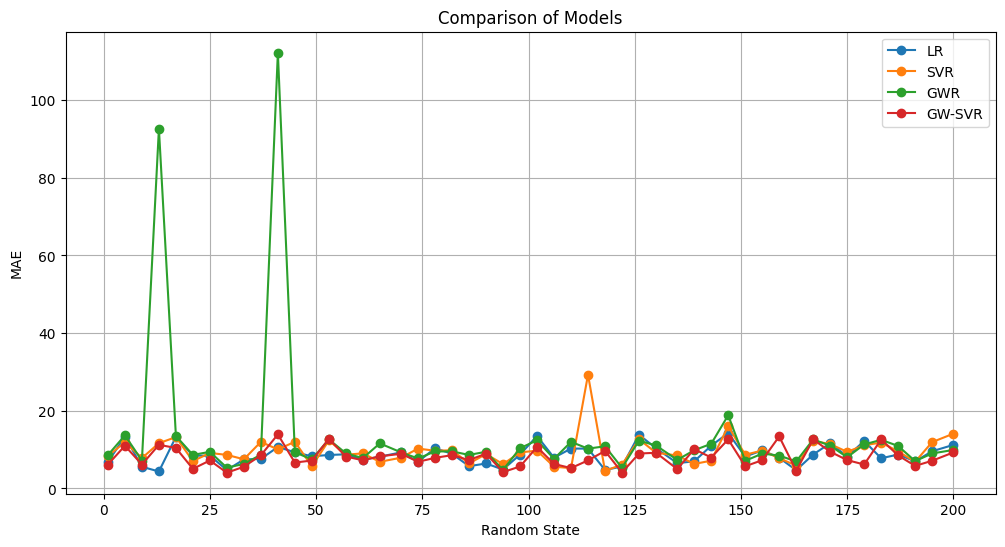

In [90]:
plt.figure(figsize=(12, 6))
for model in ['LR', 'SVR', 'GWR', 'GW-SVR']:
    mape_values = [states[rand][model]['MAE'] for rand in states.keys()]
    plt.plot(states.keys(), mape_values, marker='o', label=model)
plt.title("Comparison of Models")
plt.xlabel("Random State")
plt.ylabel("MAE")
plt.legend(loc='best')
#plt.xticks(list(states.keys()))
plt.grid()
plt.savefig('model_comparison.png')

In [91]:
states_df = (
    pd.DataFrame.from_dict(states, orient='index')
    .stack()
    .apply(pd.Series)
    .unstack()
)

In [ ]:
states_df.to_excel('states.xlsx')
